In [2]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import wasserstein_distance, gaussian_kde
import seaborn as sns
from scipy.stats import skew, kurtosis
import gymnasium as gym
from gymnasium import spaces
from torch.nn import functional as F
from sb3_contrib import RecurrentPPO
from typing import Callable
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from scipy.stats import entropy
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [51]:
lobster_data = np.load('vwap.npy')

indices = np.arange(lobster_data.shape[0])
np.random.shuffle(indices)
lobster_data = lobster_data[indices]
pct_changes = np.diff(lobster_data, axis=1) / lobster_data[:, :-1]

PCT_Prices = pct_changes[:,100:202]

In [52]:
token_limit = 0.005

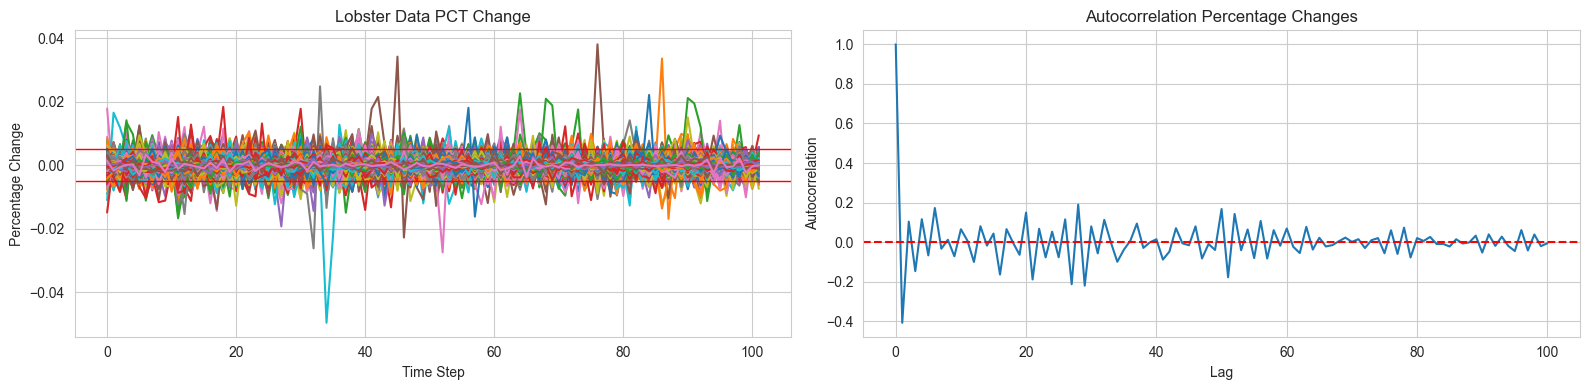

In [53]:
acf_values = acf(PCT_Prices[0], nlags=100)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

ax1.plot(PCT_Prices.T)
ax1.axhline(token_limit, color='red', linewidth=1)
ax1.axhline(-token_limit, color='red', linewidth=1)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Percentage Change')
ax1.set_title('Lobster Data PCT Change')

ax2.plot(range(len(acf_values)), acf_values)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_title('Autocorrelation Percentage Changes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

In [54]:
def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, _ = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)
    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    return tokenized_sequences

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value

    return func

def transfer_weights_from_saved(weights_path, ppo_model, transfer_head, input_dim, hidden_dim, output_dim):
    """
    Load saved supervised weights and transfer to PPO model with optional head transfer
    
    Args:
        weights_path: Path to the saved supervised model weights
        ppo_model: The PPO model to transfer weights to
        transfer_head: If True, also transfer fc layer weights to action_net
        input_dim: Input dimension of the supervised model
        hidden_dim: Hidden dimension of the supervised model
        output_dim: Output dimension of the supervised model
    """
    # Create temporary supervised model to load weights into
    temp_supervised = LSTMModel(input_dim, hidden_dim, output_dim)
    
    # Load the saved weights
    saved_weights = th.load(weights_path, weights_only=False)
    temp_supervised.load_state_dict(saved_weights['model_state_dict'])
    
    print("Loaded saved supervised weights successfully")
    
    # Transfer LSTM weights
    print("\n=== Transferring LSTM Weights ===")
    supervised_state_dict = temp_supervised.state_dict()
    ppo_lstm_dict = ppo_model.policy.lstm_actor.state_dict()
    
    # Print shapes before transfer for verification
    print("\nWeight shapes before transfer:")
    print("\nSupervised LSTM weights:")
    for key, value in supervised_state_dict.items():
        if 'lstm' in key:
            print(f"{key}: {value.shape}")
    
    print("\nPPO LSTM weights:")
    for key, value in ppo_lstm_dict.items():
        print(f"{key}: {value.shape}")
    
    # Transfer LSTM weights
    lstm_transfer_count = 0
    for ppo_key in ppo_lstm_dict.keys():
        supervised_key = f"lstm.{ppo_key}"
        if supervised_key in supervised_state_dict:
            if ppo_lstm_dict[ppo_key].shape == supervised_state_dict[supervised_key].shape:
                ppo_lstm_dict[ppo_key].copy_(supervised_state_dict[supervised_key])
                lstm_transfer_count += 1
                print(f"Transferred weights for {ppo_key}")
            else:
                print(f"Shape mismatch for {ppo_key}")
    
    # Load the LSTM weights
    ppo_model.policy.lstm_actor.load_state_dict(ppo_lstm_dict)
    print(f"\nSuccessfully transferred {lstm_transfer_count} LSTM weight tensors")
    
    # Transfer head weights if requested
    if transfer_head:
        print("\n=== Transferring Head Weights ===")
        # Get supervised fc weights and biases
        fc_weight = supervised_state_dict['fc.weight']
        fc_bias = supervised_state_dict['fc.bias']
        
        # Get PPO action_net weights and biases
        action_net_state_dict = ppo_model.policy.action_net.state_dict()
        
        print("\nHead weight shapes:")
        print(f"Supervised fc weight: {fc_weight.shape}")
        print(f"Supervised fc bias: {fc_bias.shape}")
        print(f"PPO action_net weight: {action_net_state_dict['weight'].shape}")
        print(f"PPO action_net bias: {action_net_state_dict['bias'].shape}")
        
        # Verify shapes match before transfer
        if (fc_weight.shape == action_net_state_dict['weight'].shape and 
            fc_bias.shape == action_net_state_dict['bias'].shape):
            # Transfer weights
            action_net_state_dict['weight'].copy_(fc_weight)
            action_net_state_dict['bias'].copy_(fc_bias)
            ppo_model.policy.action_net.load_state_dict(action_net_state_dict)
            print("Successfully transferred head weights")
        else:
            print("Shape mismatch in head weights - transfer aborted")
    
    return ppo_model


In [55]:
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(PCT_Prices)),5))

Standard Deviation of Price Deltas: 0.00064


In [56]:
bin_width = np.std(np.concatenate(PCT_Prices)) / 8
bin_start=-token_limit
bin_stop=token_limit
token_size = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins

token_data = tokenize_deltas(PCT_Prices, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

FUNCTIONS

In [57]:
def plot_price_token(price_data, token_data, bins, token_limit):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    ax1, ax2, ax3, ax4 = axes.ravel()

    # Time Series
    ax1.plot(price_data.T)
    ax1.axhline(token_limit, color='red', linewidth=1)
    ax1.axhline(-token_limit, color='red', linewidth=1)
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Percentage Change')
    ax1.set_title('Time Series')

    # Boxplot Time Series
    ax2.boxplot(np.concatenate(price_data), vert=True)
    ax2.axhline(token_limit, color='red', linewidth=1)
    ax2.axhline(-token_limit, color='red', linewidth=1)
    ax2.set_title('Boxplot PCT Change')
    ax2.set_ylabel('Percentage Change')

    # Histogram
    ax3.hist(np.concatenate(token_data), bins=bins, edgecolor='blue', color='orange', density=True)
    ax3.set_title('Histogram: Lobster Data PCT Change')
    ax3.set_xlabel('PCT Change')
    ax3.set_ylabel('Frequency')

    # 99% Data Histogram
    ax4.hist(np.concatenate(token_data), bins=bins, edgecolor='orange', color='blue', density=True)
    ax4.set_xlim(np.quantile(np.concatenate(token_data), q=0.005),np.quantile(np.concatenate(token_data), q=0.995))
    ax4.set_title('Histogram: 99% of Data')
    ax4.set_xlabel('PCT Change')
    ax4.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()  



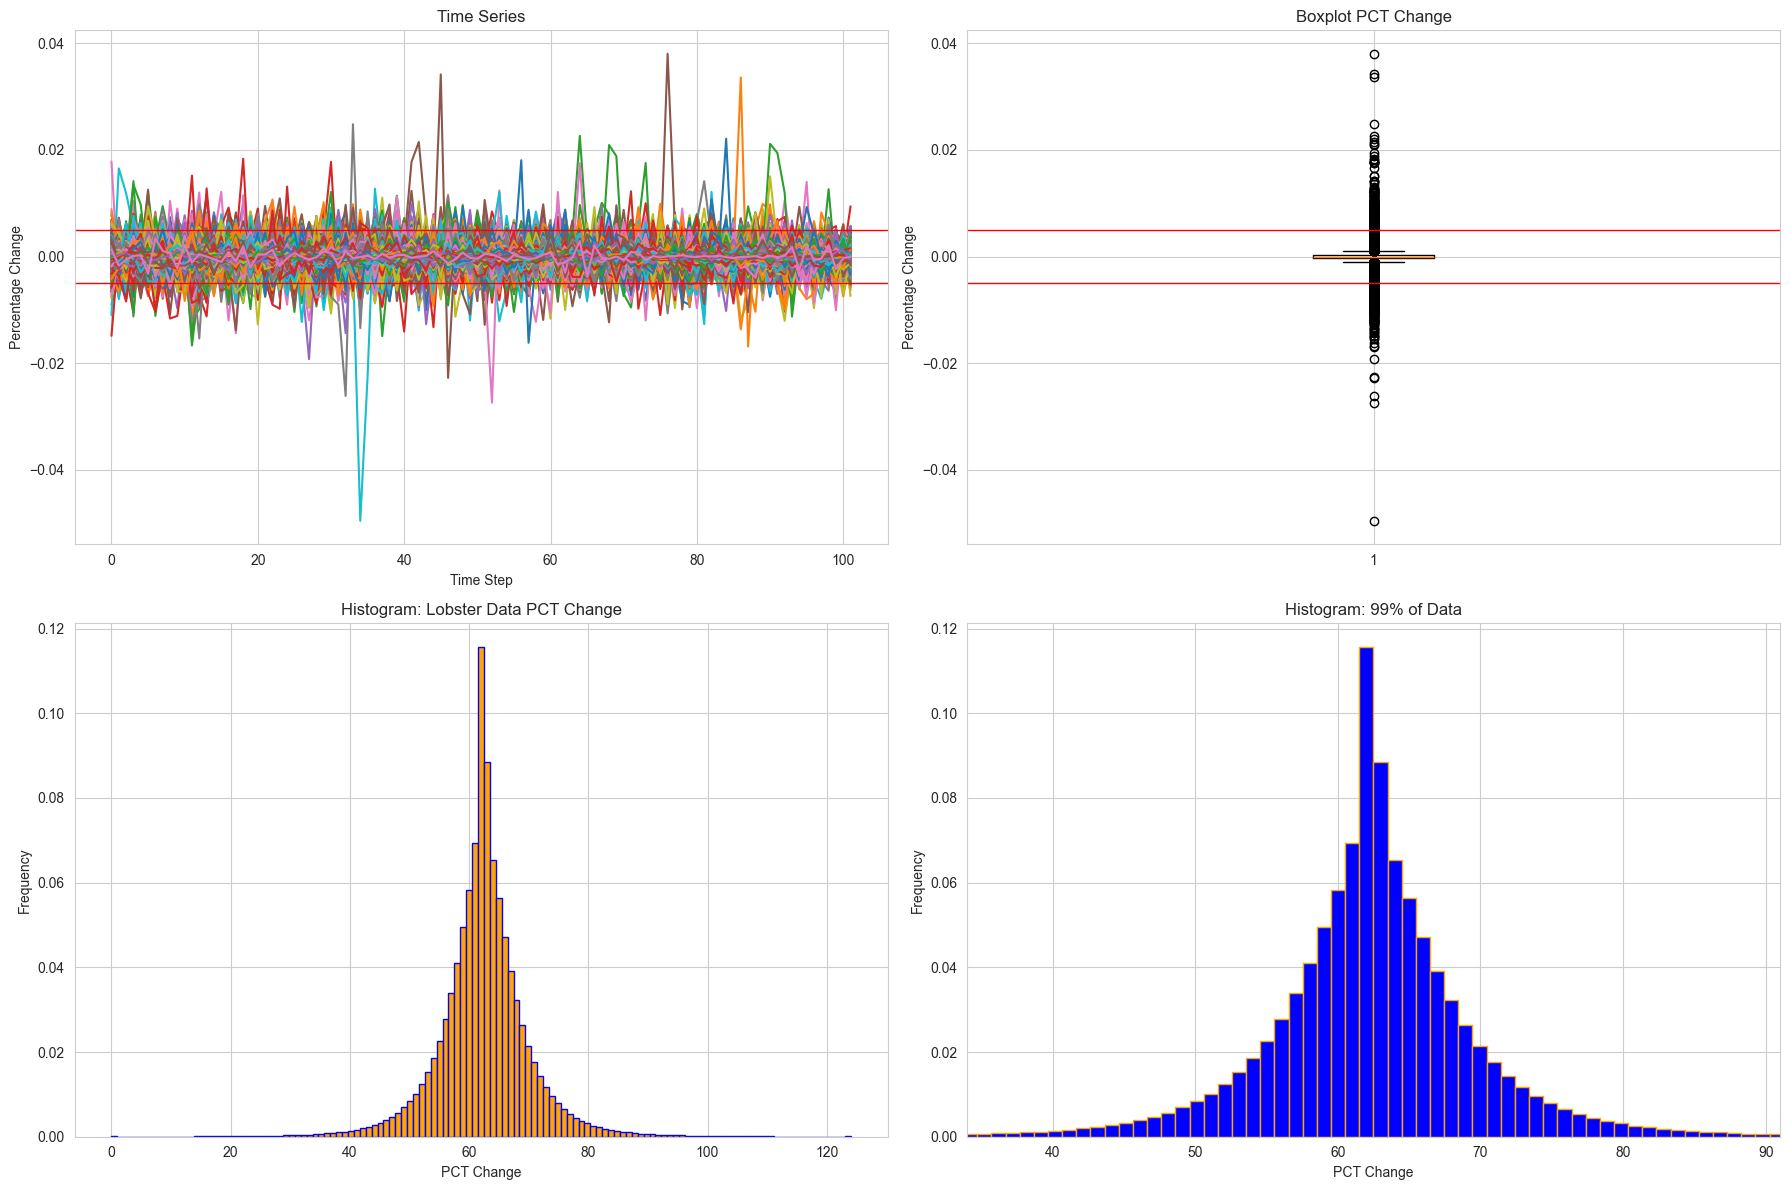

Number of Tokens: 125
Data Shape: (98087, 102)


In [58]:
plot_price_token(price_data=PCT_Prices, token_data=token_data, bins=token_size, token_limit=token_limit)

print('Number of Tokens:', token_size)
print('Data Shape:', PCT_Prices.shape)

In [59]:
n_sequences = PCT_Prices.shape[0]
n_days = PCT_Prices.shape[1]

train_size = int(0.75 * n_sequences)
val_size = int(0.075 * n_sequences)
# Split the data
train_set = PCT_Prices[:train_size]
val_set = PCT_Prices[train_size:train_size+val_size]
test_set = PCT_Prices[train_size+val_size:]

X_train = tokenize_deltas(train_set, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)
X_val = tokenize_deltas(val_set, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)
X_test = tokenize_deltas(test_set, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

# Print shapes to verify
print("Training set shape:", X_train.shape)    # Should be around (73565, 202)
print("Validation set shape:", X_val.shape)    # Should be around (12260, 202)
print("Test set shape:", X_test.shape)         # Should be around (12262, 202)

Training set shape: (73565, 102)
Validation set shape: (7356, 102)
Test set shape: (17166, 102)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Changed default input_dim
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # x shape now: [batch_size, sequence_length, vocab_size]
        lstm_out, (h_n, c_n) = self.lstm(x, hidden)
        logits = self.fc(lstm_out)
        return logits, (h_n, c_n)

def to_onehot(tokens, vocab_size):
    """Convert batch of tokens to one-hot vectors"""
    # tokens shape: [batch_size, sequence_length]
    batch_size, seq_length = tokens.shape
    onehot = th.zeros(batch_size, seq_length, vocab_size)
    for i in range(batch_size):
        for j in range(seq_length):
            onehot[i, j, tokens[i, j]] = 1
    return onehot

In [ ]:
# Rest of your parameters remain the same
hidden_dim = 128
batch_size = 512
learning_rate = 3e-4
seq_len = n_days-1
num_epochs = 30

In [ ]:
# Create model with new input dimension
model_supervised = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)

criterion_supervised = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_loss = []
val_loss = []

best_val_loss = float('inf')
max_grad_norm = 1.0

for epoch in range(num_epochs):
    
    
    temp_train_loss = []
    temp_val_loss = []

    ## ============
    ## TRAINING
    ## ============
    
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    for batch_idx in range(0, X_train.shape[0], batch_size):
        
        model_supervised.train()
        
        batch_indices = indices[batch_idx:batch_idx + batch_size]
        batch = X_train[batch_indices]

        input_tokens = th.tensor(batch[:, :-1], dtype=th.long)  # Changed to long type
        inputs = to_onehot(input_tokens, token_size)  # Convert to one-hot
        targets = th.tensor(batch[:, 1:], dtype=th.long)

        logits, _ = model_supervised(inputs, None)
        logits = logits.view(-1, logits.size(-1))
        targets = targets.view(-1)

        optimizer.zero_grad()
        
        loss = criterion_supervised(logits, targets)
        loss.backward()

        th.nn.utils.clip_grad_norm_(model_supervised.parameters(), max_grad_norm)
        
        optimizer.step()
        
        temp_train_loss.append(loss.item())

        ## ============
        ## VALIDATION
        ## ============
        
        model_supervised.eval()

        with th.no_grad():
            # Main changes here: convert inputs to one-hot
            input_tokens = th.tensor(X_val[:2000, :-1], dtype=th.long)  # Changed to long type
            inputs = to_onehot(input_tokens, token_size)  # Convert to one-hot
            targets = th.tensor(X_val[:2000, 1:], dtype=th.long)

            logits, _ = model_supervised(inputs, None)
            logits = logits.view(-1, logits.size(-1))
            targets = targets.contiguous().reshape(-1)
            loss = criterion_supervised(logits, targets)
            temp_val_loss.append(loss.item())
        
        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            checkpoint = {
                'model_state_dict': model_supervised.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()  # Fixed: use optimizer state
                }
            th.save(checkpoint, 'supervised_weights_lobster.pth')
        
        print(f"Train Loss: {temp_train_loss[-1]:.4} - Val Loss: {temp_val_loss[-1]:.4}")
    
    train_loss.extend(temp_train_loss)
    val_loss.extend(temp_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_train_loss):.4f} - Val Loss: {np.mean(temp_val_loss):.4f}")

In [ ]:
# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_loss, label='Training Loss', color='skyblue', linewidth=1.5)
plt.plot(val_loss, label='Validation Loss', color='blue', linewidth=1.5)
plt.title('Training vs. Validation Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()